In [ ]:
!apt-get -y install libenchant-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant-dev libenchant1c2a libhunspell-1.6-0
  libtext-iconv-perl
0 upgraded, 11 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,362 kB of archives.
After this operation, 5,602 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv

In [ ]:
!pip install pyenchant

     |████████████████████████████████| 61kB 1.8MB/s 


In [ ]:
import re
import enchant
import nltk

from nltk.corpus import stopwords, words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import files
data_to_load = files.upload()

Saving formspring_data.csv to formspring_data.csv


In [ ]:
df = pd.read_csv('formspring_data.csv', sep='\t')

In [ ]:
df

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12768,outlaw9000,Q: Youre at a party and your friend who drove ...,Youre at a party and your friend who drove you...,take the battery cable off and make her sta...,None,No,0,NaN,No,0,NaN,No,0,NaN
12769,outlaw9000,Q: Youu2019re awesome :] Give yourself a compl...,Youu2019re awesome :] Give yourself a complime...,thank you ! ! I AM Awesome ! !,None,No,0,None,No,0,NaN,No,0,NaN
12770,outlaw9000,Q: Yu play with yurself ?<br>A: all the time. ...,Yu play with yurself ?,all the time. sometimes more than once a day,None,No,0,NaN,No,0,NaN,No,0,NaN
12771,outlaw9000,Q: yukk beer is disgusting. i can only drink i...,yukk beer is disgusting. i can only drink it w...,oh O.K ! ! nice make sure it's Stolie's Please,None,No,0,NaN,No,0,NaN,No,0,NaN


In [ ]:
df.columns

Index(['userid', 'post', 'ques', 'ans', 'asker', 'ans1', 'severity1', 'bully1',
       'ans2', 'severity2', 'bully2', 'ans3', 'severity3', 'bully3'],
      dtype='object')

In [ ]:
df.describe()

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
count,12773,12773,12771,12770,12773,12731,12772,1909,12735,12773,1806,12728,12773,1826
unique,49,12771,12326,11993,552,2,12,1013,2,15,1002,2,15,982
top,zooshay,Q: Wait. Are you Cheyenne? I sent a request to...,hi,nope,None,No,0,None,No,0,None,No,0,None
freq,2245,2,7,50,6790,11693,11484,593,11710,11526,527,11740,11514,551


**Three Results**
 The data has three results, and I would like to only view data where all the three results match.

In [ ]:
sum(df.ans1 == df.ans2) / len(df)


0.9087919830893291

In [ ]:
sum(df.ans2 == df.ans3) / len(df)

0.9145071635481093

In [ ]:
sum(df.ans1 == df.ans3) / len(df)

0.9112189775307289

In [ ]:
index = (df.ans1 == df.ans2) & (df.ans2 == df.ans3) & (df.ans1 == df.ans3)  
 ##A post was considered harmful if atleast two out of three annotators answered “yes” for the primary question.

In [ ]:
df = df[index]

In [ ]:
df

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12766,outlaw9000,Q: Your parents are divorced. One of them gets...,Your parents are divorced. One of them gets ma...,Not incest because we would not be related s...,None,No,0,NaN,No,0,NaN,No,0,NaN
12768,outlaw9000,Q: Youre at a party and your friend who drove ...,Youre at a party and your friend who drove you...,take the battery cable off and make her sta...,None,No,0,NaN,No,0,NaN,No,0,NaN
12769,outlaw9000,Q: Youu2019re awesome :] Give yourself a compl...,Youu2019re awesome :] Give yourself a complime...,thank you ! ! I AM Awesome ! !,None,No,0,None,No,0,NaN,No,0,NaN
12770,outlaw9000,Q: Yu play with yurself ?<br>A: all the time. ...,Yu play with yurself ?,all the time. sometimes more than once a day,None,No,0,NaN,No,0,NaN,No,0,NaN


In [ ]:
# Putting back apostrophe's may help
df.ques = df.ques.str.replace("&#039;", "'") 

# Removing may not be effective since there is a word check implemented
df.ques = df.ques.str.replace("<br>", "") 
df.ques = df.ques.str.replace("&quot;", "") 
df.ques = df.ques.str.replace("<3", "") 

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what's your favorite song? :D,I like too many songs to have a favorite,None,No,0,NaN,No,0,NaN,No,0,NaN
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,,</3 ? haha jk! <33,None,No,0,NaN,No,0,NaN,No,0,NaN
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,hey angel you duh sexy,Really?!?! Thanks?! haha,None,No,0,NaN,No,0,NaN,No,0,NaN
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,NaN,No,0,NaN,No,0,NaN
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,NaN,No,0,NaN,No,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12766,outlaw9000,Q: Your parents are divorced. One of them gets...,Your parents are divorced. One of them gets ma...,Not incest because we would not be related s...,None,No,0,NaN,No,0,NaN,No,0,NaN
12768,outlaw9000,Q: Youre at a party and your friend who drove ...,Youre at a party and your friend who drove you...,take the battery cable off and make her sta...,None,No,0,NaN,No,0,NaN,No,0,NaN
12769,outlaw9000,Q: Youu2019re awesome :] Give yourself a compl...,Youu2019re awesome :] Give yourself a complime...,thank you ! ! I AM Awesome ! !,None,No,0,None,No,0,NaN,No,0,NaN
12770,outlaw9000,Q: Yu play with yurself ?<br>A: all the time. ...,Yu play with yurself ?,all the time. sometimes more than once a day,None,No,0,NaN,No,0,NaN,No,0,NaN


In [ ]:
bully_df = df[df.ans1 == "Yes"].reset_index(drop=True)
df[df.ans1 == "Yes"].head()                                      

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
38,aprilpooh15,Q: Fuck Justin bieber. He&#039;s a fucking fag...,Fuck Justin bieber. He's a fucking fag,UM excuse yuh? HE IS NOT!! Ur a fuckin idiot!...,None,Yes,1,Ur a fuckin idiot!,Yes,5,Ur a fuckin idiot,Yes,5,Ur a fuckin idiot
62,aprilpooh15,Q: Hey. Why you such a bitch?<br>A: Why thank ...,Hey. Why you such a bitch?,Why thank yuh!,None,Yes,3,"""""""why you such a bitch?""""""",Yes,5,"""""""Bitch""""""",Yes,9,Why you such a bitch?
191,aprilpooh15,Q: who decided to take a shit on your face?<br...,who decided to take a shit on your face?,im not quite sure! ill tell ya when i find ou...,None,Yes,2,shit on your face,Yes,2,who decided to take a shit on your face?,Yes,5,shit on your face
200,aprilpooh15,Q: Why do u follow the bandwagon? Formspring. ...,Why do u follow the bandwagon? Formspring. Twi...,Well im not following anything and really BAN...,None,Yes,2,Idiot! Cnt spell!,Yes,4,"""""""gay""""""",Yes,2,"""""""Gay"""""""
244,joielovesu,Q: lmao.. &quot;yurr reall funny skinny ass bi...,lmao.. yurr reall funny skinny ass bitchh.. hm...,ahhaha yuurr funnyy reall funny ndd i dntt wa...,None,Yes,8,"""""""bitchh"""" """"talkn shit"""" """"white trash skank...",Yes,10,"""""""Q: lmao.. """"yurr reall funny skinny ass bit...",Yes,10,Later white trash skank. BITCH!


**Tokenizer**
Build a custom function that can gather actual words from a give string.

In [ ]:
stop_words = stopwords.words("english")  ##English words which does not add much meaning to a sentence.
lemmatizer = WordNetLemmatizer() 
enchant_dict = enchant.Dict("en_US")     ##used to check the spelling of a word, gives suggestions to correct words.

def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    #tokens = [word for word in tokens if enchant_dict.check(word)]

    return tokens

In [ ]:
for i in range(0,339):      #range..339
    print(bully_df.ques[i])
    print(tokenize(bully_df.ques[i]),"\n")

Fuck Justin bieber. He's a fucking fag
['fuck', 'justin', 'bieber', 'fucking', 'fag'] 

Hey. Why you such a bitch?
['hey', 'bitch'] 

who decided to take a shit on your face?
['decided', 'take', 'shit', 'face'] 

Why do u follow the bandwagon? Formspring. Twitter. What's next gay Justin beiber.
['u', 'follow', 'bandwagon', 'formspring', 'twitter', 'next', 'gay', 'justin', 'beiber'] 

lmao.. yurr reall funny skinny ass bitchh.. hm.. that isn't really much of an insult now is it? what if i was fat? lol u suck at talkn shit :] later white trash skank :] ur super ugly nd that guy u like really isnt gonna come back around for u. laterrrr
['lmao', 'yurr', 'reall', 'funny', 'skinny', 'as', 'bitchh', 'hm', 'really', 'much', 'insult', 'fat', 'lol', 'u', 'suck', 'talkn', 'shit', 'later', 'white', 'trash', 'skank', 'ur', 'super', 'ugly', 'nd', 'guy', 'u', 'like', 'really', 'isnt', 'gon', 'na', 'come', 'back', 'around', 'u', 'laterrrr'] 

lol how cute u have friends that back u up :] doesnt matter

In [ ]:
bully_df

,userid,post,ques,ans,asker,ans1,severity1,bully1,ans2,severity2,bully2,ans3,severity3,bully3
0,aprilpooh15,Q: Fuck Justin bieber. He&#039;s a fucking fag...,Fuck Justin bieber. He's a fucking fag,UM excuse yuh? HE IS NOT!! Ur a fuckin idiot!...,None,Yes,1,Ur a fuckin idiot!,Yes,5,Ur a fuckin idiot,Yes,5,Ur a fuckin idiot
1,aprilpooh15,Q: Hey. Why you such a bitch?<br>A: Why thank ...,Hey. Why you such a bitch?,Why thank yuh!,None,Yes,3,"""""""why you such a bitch?""""""",Yes,5,"""""""Bitch""""""",Yes,9,Why you such a bitch?
2,aprilpooh15,Q: who decided to take a shit on your face?<br...,who decided to take a shit on your face?,im not quite sure! ill tell ya when i find ou...,None,Yes,2,shit on your face,Yes,2,who decided to take a shit on your face?,Yes,5,shit on your face
3,aprilpooh15,Q: Why do u follow the bandwagon? Formspring. ...,Why do u follow the bandwagon? Formspring. Twi...,Well im not following anything and really BAN...,None,Yes,2,Idiot! Cnt spell!,Yes,4,"""""""gay""""""",Yes,2,"""""""Gay"""""""
4,joielovesu,Q: lmao.. &quot;yurr reall funny skinny ass bi...,lmao.. yurr reall funny skinny ass bitchh.. hm...,ahhaha yuurr funnyy reall funny ndd i dntt wa...,None,Yes,8,"""""""bitchh"""" """"talkn shit"""" """"white trash skank...",Yes,10,"""""""Q: lmao.. """"yurr reall funny skinny ass bit...",Yes,10,Later white trash skank. BITCH!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,outlaw9000,Q: okay i added some people who want sexual s...,okay i added some people who want sexual spam...,okies,None,Yes,1,some people who want sexual spam i dont do tha...,Yes,6,sexual spam,Yes,6,sexual spam
335,outlaw9000,Q: r u a drty slut?<br>A: yep ! !,r u a drty slut?,yep ! !,None,Yes,4,r u a dirty slut,Yes,3,dirty slut,Yes,2,drty slut
336,outlaw9000,Q: When caught early the embryo isn&#039;t mu...,When caught early the embryo isn't much diffe...,I'm tired of debating this with you. I have s...,None,Yes,1,get rid of it,Yes,3,killing sperm,Yes,7,Q: When caught early the embryo isn't much dif...
337,outlaw9000,Q: You&#039;re a bushwhacking alchy piece of ...,You're a bushwhacking alchy piece of shit scrub.,and you're blocked,None,Yes,3,piece of shit,Yes,9,You're a bushwhacking alchy piece of shit scrub,Yes,6,You're a bushwhacking alchy piece of shit scrub.


In [ ]:
df['ans']

0                 I like too many songs to have a favorite
1                                       </3 ? haha jk! <33
2                                 Really?!?! Thanks?! haha
3                                                       ;(
4                                                  *RAWR*?
                               ...                        
12766     Not incest  because we would not be related s...
12768     take the battery cable off   and make her sta...
12769                       thank you ! ! I AM Awesome ! !
12770         all the time. sometimes more than once a day
12771       oh O.K ! ! nice make sure it's Stolie's Please
Name: ans, Length: 11089, dtype: object

In [ ]:
bully_df.shape

(339, 14)

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#loading all necessary libraries
import numpy as np
import pandas as pd

import string
import collections
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
##all_bully = bully_df['bully1'].str.split(' ')
all_bully.head()

In [ ]:
##ll_bully_cleaned= []

for bully1 in all_bully:
     bully1 = [x.strip(string.punctuation) for x in bully1]
     all_bully_cleaned.append(bully1)

     
##all_bully_cleaned[0]

text_bully = [" ".join(bully1) for bully1 in all_bully_cleaned]
final_text = " ".join(text_bully)
final_text[:1000]

In [ ]:
all_bully = bully_df['ques'].str.split(' ')
all_bully.head()

0       [Fuck, Justin, bieber., He's, a, fucking, fag]
1                    [Hey., Why, you, such, a, bitch?]
2    [who, decided, to, take, a, shit, on, your, fa...
3    [Why, do, u, follow, the, bandwagon?, Formspri...
4    [lmao.., yurr, reall, funny, skinny, ass, bitc...
Name: ques, dtype: object

In [ ]:
all_bully_cleaned= []

for ques in all_bully:
     ques = [x.strip(string.punctuation) for x in ques]
     all_bully_cleaned.append(ques)

     
all_bully_cleaned[0]

text_bully = [" ".join(ques) for ques in all_bully_cleaned]
final_text = " ".join(text_bully)
final_text[:1000]



"Fuck Justin bieber He's a fucking fag Hey Why you such a bitch who decided to take a shit on your face Why do u follow the bandwagon Formspring Twitter What's next gay Justin beiber lmao yurr reall funny skinny ass bitchh hm that isn't really much of an insult now is it what if i was fat lol u suck at talkn shit  later white trash skank  ur super ugly nd that guy u like really isnt gonna come back around for u laterrrr lol how cute u have friends that back u up  doesnt matter ur still a fake bitch  go find a real bf not someone out of ur league lol ugly ass shit talkin bitch still a bitch  whyy aree youu suchh aa faggottt your ugly I have one for your information WTF That's MY LIFE  NOT YOURS You best think twice before you try to steal my stuff  bitch Show your face Anonymous WTF You make no sense you fake ugly bitch are you all you can say lmfaoo well  your fake everyone knows it  no need to go on about it sayoonarra  im sorry  im not the one being a fake of some lady lol comeon now

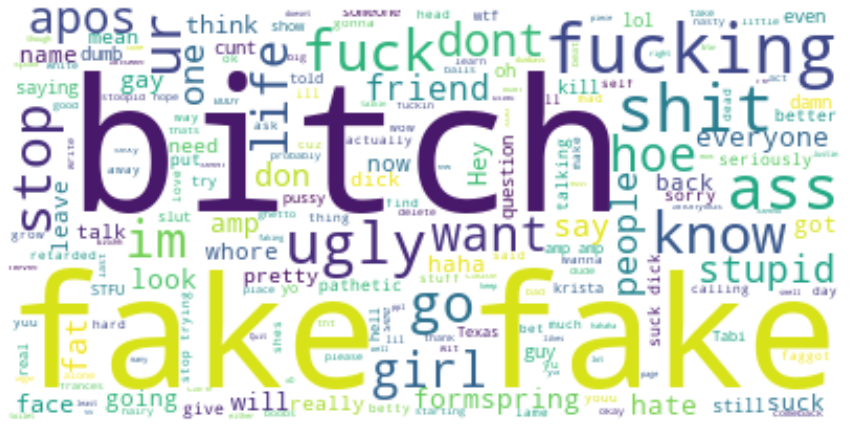

In [ ]:
wordcloud_bully = WordCloud(background_color="white").generate(final_text)


plt.figure(figsize = (15,15))
plt.imshow(wordcloud_bully, interpolation='bilinear')
plt.axis("off")
plt.show()

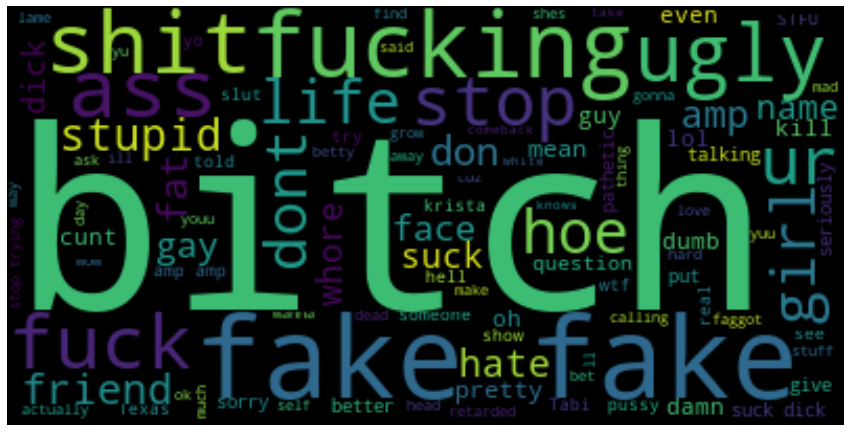

In [ ]:
stopwords = set(STOPWORDS)   ###Removing words such as dont/ want which do not provide insights
stopwords.update(["want","go","formspring","know", "talk","u","Your","don&#39;t","need","still","saying","everyone","I","You","YOU","say","A","Hey", "back","one","people","going","now","really","leave","im","haha","will","got","look","think","apos"])

wordcloud_bully = WordCloud(stopwords=stopwords, background_color="black", max_font_size=120, max_words=100).generate(final_text)


plt.figure(figsize = (15,15))
plt.imshow(wordcloud_bully, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
##extracting the most popular words as a frequency table.
filtered_words_bully = [word for word in final_text.split() if word not in stopwords]
counted_words_bully = collections.Counter(filtered_words_bully)

word_count_bully = {}

for letter, count in counted_words_bully.most_common(20):
    word_count_bully[letter] = count
    
for i,j in word_count_bully.items():
        print('Word: {0}, count: {1}'.format(i,j))

Word: fake, count: 78
Word: bitch, count: 60
Word: fucking, count: 40
Word: ass, count: 37
Word: shit, count: 36
Word: ugly, count: 33
Word: fuck, count: 26
Word: ur, count: 23
Word: stop, count: 22
Word: life, count: 16
Word: dont, count: 16
Word: stupid, count: 16
Word: hoe, count: 16
Word: suck, count: 14
Word: dick, count: 14
Word: fat, count: 12
Word: face, count: 11
Word: gay, count: 11
Word: girl, count: 11
Word: hate, count: 11


<Figure size 3600x2160 with 0 Axes>

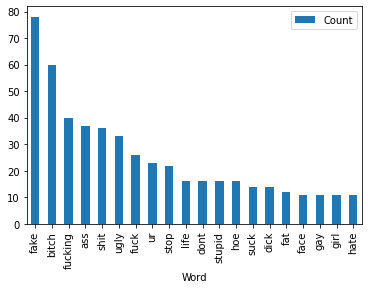

In [ ]:
lst = counted_words_bully.most_common(20)
fig= plt.figure(figsize=(50,30))
df = pd.DataFrame(lst, columns = ['Word', 'Count'])
df.plot.bar(x='Word',y='Count')
